Morgan Turville-Heitz
CS 760
11/5/2023

In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [260]:
def xbar(D):
    mean_vector = D.mean(axis=1)
    return mean_vector

In [261]:
def stddv(D):
    sigma = D.std(axis = 1)
    return sigma

In [262]:
def svdX(D):
    U, S, VT = np.linalg.svd(D, full_matrices=True)
    return U, S, VT



$$ A \in \mathbb{R}^{d \times D} $$

In [263]:
def buggy_PCA(X, d):

    #print(f"Shape of X is {X.shape}")
    ### Not reducing the values of the SVD decomp, and instead simply iterating through k = 1:d    
    U, S, VT = svdX(X) 
    
    ### D dimensions, d-dimensional subspace projection
    #print(f"Shape of VT is {VT.shape}")
    A = VT[:d, :].T
    #print(f"Shape of A is {A.shape}")

    Z = np.matmul(X, A)
    #print(f"Z shape is {Z.shape}")

    Xr = np.matmul(Z, A.T)
    #print(f"Xr is shape {Xr.shape}")

    return Z,  A, Xr, U, S, VT
#Z, A, Xr, U, S, VT = buggy_PCA(Data2D, 1)
#print(Data2D)
#print(Xr)

In [264]:
def demeaned_PCA(X_, d):

    means = xbar(X_)

    #print(f"Shapes are: X_ : {X_.shape}, xbar: {means.shape}")
    #print(f"X_ is {X_}")
    X = X_.subtract(means, axis=0)

    #print(f"X centered is {X}")
    
    #print(f"Shape of X is {X.shape}")
    ### Not reducing the values of the SVD decomp, and instead simply iterating through k = 1:d    
    U, S, VT = svdX(X) 

    ### D dimensions, d-dimensional subspace projection
    #print(f"Shape of VT is {VT.shape}")
    A = VT[:d, :].T
    #print(f"Shape of A is {A.shape}")

    Z = np.matmul(X, A)
    #print(f"Z shape is {Z.shape}")

    Xr_ = np.matmul(Z, A.T)
    #print(f"Xr is shape {Xr.shape}")

    Xr = Xr_.add(means, axis = 0)
    #print(f"X is {X_}")  
    #print(F"Reconstructed Xr is {Xr}")
    return Z,  A, Xr, U, S, VT

#Z, A, Xr, U, S, VT = demeaned_PCA(Data2D, 1)


In [265]:
def normalized_PCA(X_, d):

    means = xbar(X_)

    #print(f"Shapes are: X_ : {X_.shape}, xbar: {means.shape}")
    #print(f"X_ is {X_}")
    Xd = X_.subtract(means, axis=0)
    
    sigma = stddv(Xd)

    X = Xd.divide(sigma, axis = 0)

    #print(f"X centered and normalized is is {X}")
    
    #print(f"Shape of X is {X.shape}")
    ### Not reducing the values of the SVD decomp, and instead simply iterating through k = 1:d    
    U, S, VT = svdX(X) 

    ### D dimensions, d-dimensional subspace projection
    #print(f"Shape of VT is {VT.shape}")
    A = VT[:d, :].T
    #print(f"Shape of A is {A.shape}")

    Z = np.matmul(X, A)
    #print(f"Z shape is {Z.shape}")

    Xr__ = np.matmul(Z, A.T)
    #print(f"Xr is shape {Xr.shape}")
    Xr_ = Xr__.multiply(sigma, axis = 0)

    Xr = Xr_.add(means, axis = 0)

    #print(f"Reconstructed Xr is {Xr}")
    return Z,  A, Xr, U, S, VT

#Z, A, Xr, U, S, VT = normalized_PCA(Data2D, 1)

In [331]:
def DRO(X__, d):
    #print(f"Data shape is {X__.shape}")
    X_ = X__.T
    eps = 1e-7
    ### Centering the data    
    Xbar = xbar(X_).values
    #print(f"Type of X_ is {type(X_)}")
    #print(f"Shapes are: X_ : {X_.shape}, xbar: {means.shape}")
    #print(f"X_ is {X_}")
    Xc = X_ - Xbar[:, np.newaxis]  
    U, S, VT = svdX(Xc)
    Ud = U[:, :d]
    Sd = S[:d]
    VTd = VT[:d, :]
    #print(f"S is {S}, Sd is {Sd}")
    A = VTd
    print(f"Ud shape is {Ud.shape}, Sd.diag shape is {np.diag(Sd).shape}, A shape is {VTd.shape}")
    Z = np.dot(Ud,np.diag(Sd))
    print(f"Z shape is {Z.shape}")
    sigmas = stddv(Z.T)
    #print(f"Sigmas are: {sigmas}")
    #sigmas = sigmas[:, np.newaxis]
    sigmas[sigmas < eps] = eps
    #print(sigmas)
    print(f"Shape of Z: {Z.shape}, Shape of sigmas: {sigmas.shape}")
    #print(f"Z: {Z}")
    Zscaled = Z / sigmas
    #print(f"Zscaled: {Zscaled}")
    #print(f"Shapes are: VTd: {VTd.shape}, Zscaled: {Zscaled.shape}")
    Xr_ = Zscaled @ VTd
    #print(f"Type of Xr_ is {type(Xr_)}, Type of b is {type(b)}")
    Xr = Xr_ + Xbar[:, np.newaxis]
    #print(f"Xr is {Xr}")
    return Zscaled, A, Xr, U, S, VT, Xbar
Zscaled, A, Xr, U, S, VT, Xbar = DRO(Data1000D, 200)
print(f"Shapes of data are: XR:{Xr.shape}, X:{Data1000D.shape}")
print(reconstruction_error(Data1000D, Xr.T))
#print(type(Xr))

Ud shape is (500, 200), Sd.diag shape is (200, 200), A shape is (200, 1000)
(500, 200)
Shape of Z: (500, 200), Shape of sigmas: (200,)
Shapes of data are: XR:(500, 1000), X:(1000, 500)

(41508550.931943566, 83017.10186388713)


In [267]:
num_columns_2d = 2  
column_names_2d = ['X_' + str(i) for i in range(1, num_columns_2d + 1)]
Data2D = pd.read_csv('data2D.csv', header=None, names=column_names_2d)

num_columns_1000d = 1000  
column_names_1000d = ['X_' + str(i) for i in range(1, num_columns_1000d + 1)]
Data1000D = pd.read_csv('data1000D.csv', header=None, names=column_names_1000d)

### Transposing such that we have n columns, D rows
Data2D = Data2D.transpose()
Data1000D = Data1000D.transpose()



In [268]:
errors_d1000 = {'buggy': [], 'demeaned': [], 'normalized': [], 'dro' : []}
Xr_d1000 = {'buggy': [], 'demeaned': [], 'normalized': [], 'dro' : []}

In [273]:
def reconstruction_error(X, Xr):
    print()
    X = X.T
    Xr = Xr.T
    #print(f"Error shapes: check dimensionality: X shape = {X.shape}, Xr shape = {Xr.shape}")
    
    errors = np.sum((X - Xr)**2, axis=1)
    
    # Sum the squared errors for all data points
    total_error = np.sum(errors)
    
    # Average error per data point
    error_n = total_error / len(X)
    
    return total_error, error_n


2D Data Calculations

In [270]:
### D2
errors_d2 = {'buggy': [], 'demeaned': [], 'normalized': [], 'dro' : []}
Xr_d2 = {'buggy': [], 'demeaned': [], 'normalized': [], 'dro' : []}


row, col = Data2D.shape

Z, A, Xr, U, S, VT = buggy_PCA(Data2D, 1)
Xr_d2['buggy'] = Xr
errors_d2['buggy'] = [1, reconstruction_error(Data2D, Xr)]

Z, A, Xr, U, S, VT = demeaned_PCA(Data2D, 1)
Xr_d2['demeaned'] = Xr
errors_d2['demeaned'] = [1, reconstruction_error(Data2D, Xr)]

Z, A, Xr, U, S, VT = normalized_PCA(Data2D, 1)
Xr_d2['normalized'] = Xr
errors_d2['normalized'] = [1, reconstruction_error(Data2D, Xr)]

Z, A, Xr, U, S, VT, Xbar = DRO(Data2D, 1)
Xr_d2['dro'] = Xr
errors_d2['dro'] = [1, reconstruction_error(Data2D, Xr)]



Error shapes: check dimensionality: X shape = (50, 2), Xr shape = (50, 2)

Error shapes: check dimensionality: X shape = (50, 2), Xr shape = (50, 2)

Error shapes: check dimensionality: X shape = (50, 2), Xr shape = (50, 2)

Error shapes: check dimensionality: X shape = (50, 2), Xr shape = (50, 2)


In [271]:
for key in errors_d2.keys():
    print(f"Errors for {key} are {errors_d2[key]}")

Errors for buggy are [1, (44.34515418673971, 0.8869030837347942)]
Errors for demeaned are [1, (0.5003042814256461, 0.010006085628512922)]
Errors for normalized are [1, (2.4736041727385336, 0.04947208345477067)]
Errors for dro are [1, (0.049471324806812586, 0.0009894264961362517)]


Here I am determining the saddlepoints of $\Sigma$ under different approaches. I wanted to look at how the value of $\Sigma$ changes for DRO as well, where there is a significant difference in the calculation of the SVD.

In [304]:
###
Sigmas = {'buggy': [], 'demeaned': [], 'normalized': [], 'DRO' : []}
XR = {'buggy': [], 'demeaned': [], 'normalized': [], 'DRO' : []}


Z, A, Xr, U, S, VT = buggy_PCA(Data1000D, 499)
Sigmas['buggy'] = S
XR['buggy'] = Xr


#print(S.shape)
Z, A, Xr, U, S, VT = demeaned_PCA(Data1000D, 499)
Sigmas['demeaned'] = S
XR['demeaned'] = Xr
#print(type(S))

Z, A, Xr, U, S, VT = normalized_PCA(Data1000D, 499)
Sigmas['normalized'] = S
XR['normalized'] = Xr

#print([(i, s) for i, s in enumerate(S[:40], start=1)])

Z, A, Xr, U, S, VT, Xbar = DRO(Data1000D, 499)
Sigmas['DRO'] = S
XR['DRO'] = Xr




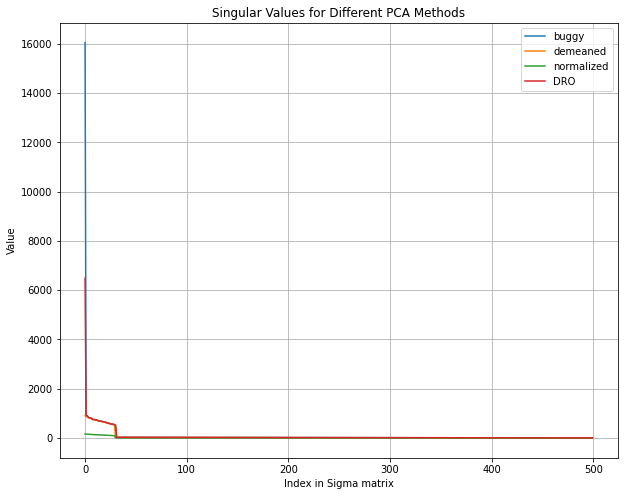

In [289]:
plt.figure(figsize=(10, 8))
for key, values in Sigmas.items():
    plt.plot(values, label=key)
plt.title('Singular Values for Different PCA Methods')
plt.xlabel('Index in Sigma matrix')
plt.ylabel('Value')
plt.legend()
#plt.yscale('log')  # Use logarithmic scale for better visibility if values vary greatly
plt.grid(True)
plt.show()



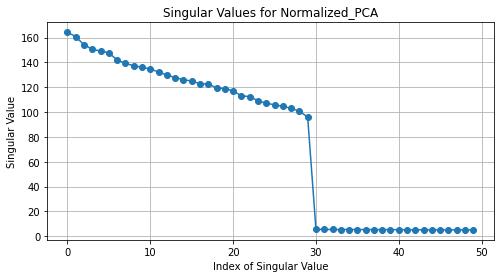

In [295]:
values = Sigmas['normalized']
plt.figure(figsize=(8, 4))
plt.plot(values[:50], marker='o')
plt.title(f'Singular Values for Normalized_PCA')
plt.xlabel('Index of Singular Value')
plt.ylabel('Singular Value')
#plt.yscale('log')  # Logarithmic scale for better visibility
plt.grid(True)
plt.show()

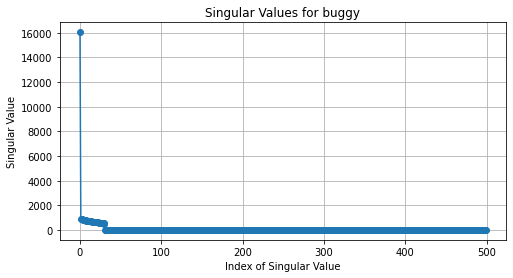

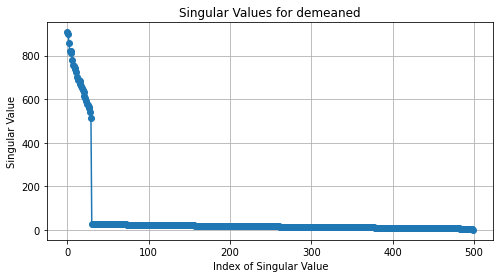

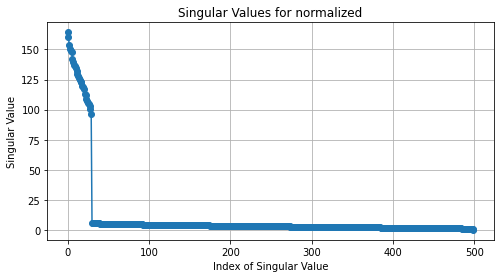

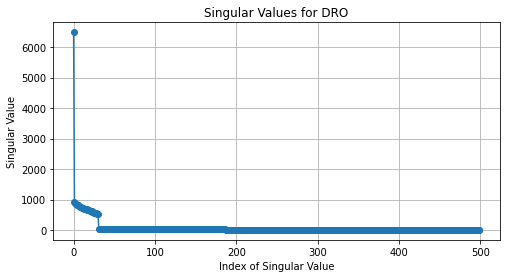

In [290]:
for key, values in Sigmas.items():
    plt.figure(figsize=(8, 4))
    plt.plot(values, marker='o')
    if str(key) == 'Untouched':
        plt.title(f'Singular Values for original data (X = U S VT)')
    else:
        plt.title(f'Singular Values for {key}')
    plt.xlabel('Index of Singular Value')
    plt.ylabel('Singular Value')
    #plt.yscale('log')  # Logarithmic scale for better visibility
    plt.grid(True)
    plt.show()

In [305]:
###
Sigmas = {'buggy': [], 'demeaned': [], 'normalized': [], 'DRO' : []}
XR = {'buggy': [], 'demeaned': [], 'normalized': [], 'DRO' : []}


Z, A, Xr, U, S, VT = buggy_PCA(Data2D, 1)
Sigmas['buggy'] = S
XR['buggy'] = Xr


#print(S.shape)
Z, A, Xr, U, S, VT = demeaned_PCA(Data2D, 1)
Sigmas['demeaned'] = S
XR['demeaned'] = Xr
#print(type(S))

Z, A, Xr, U, S, VT = normalized_PCA(Data2D, 1)
Sigmas['normalized'] = S
XR['normalized'] = Xr

#print([(i, s) for i, s in enumerate(S[:40], start=1)])

Z, A, Xr, U, S, VT, Xbar = DRO(Data2D, 1)
Sigmas['DRO'] = S
XR['DRO'] = Xr

Shape of X is (50, 2)
Shape of Xr for buggy is (50, 2)


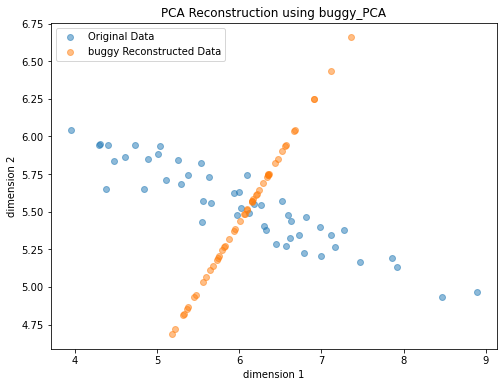

Shape of X is (50, 2)
Shape of Xr for demeaned is (50, 2)


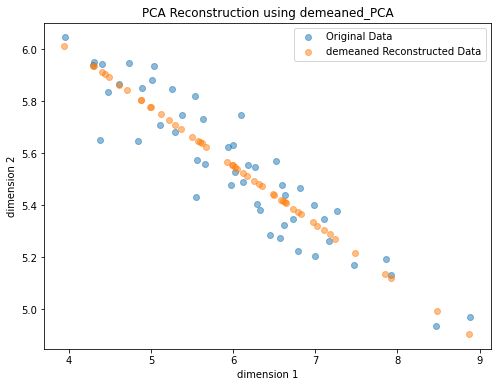

Shape of X is (50, 2)
Shape of Xr for normalized is (50, 2)


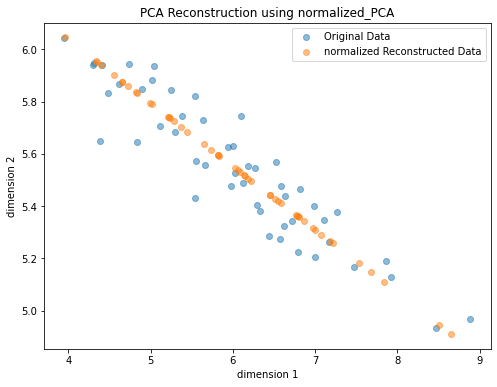

Shape of X is (50, 2)
Shape of Xr for DRO is (50, 2)


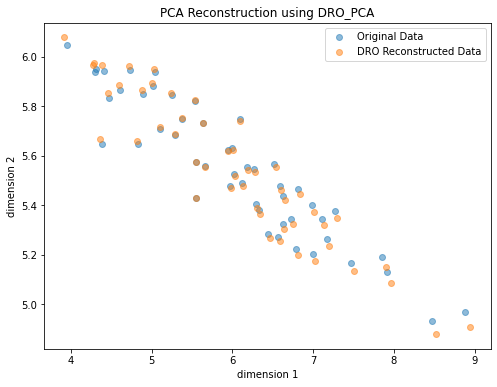

In [314]:

for key in Sigmas.keys():
    plt.figure(figsize=(8, 6))
    
    # Convert Data2D DataFrame to numpy array for plotting
    Data2D = Data2D
    print(f"Shape of X is {Data2D.shape}")
    Data2D_np = Data2D.to_numpy()
    # Plot the original data
    plt.scatter(Data2D_np[:, 0], Data2D_np[:, 1], alpha=0.5, label='Original Data')
    
    # Plot the reconstructed data
    Xr_np = np.array(XR[key])  # Ensure XR[key] is a NumPy array
    Xr_np = Xr_np.T
    print(f"Shape of Xr for {key} is {Xr_np.shape}")

    plt.scatter(Xr_np[:, 0], Xr_np[:, 1], alpha=0.5, label=f'{key} Reconstructed Data')
    
    plt.title(f'PCA Reconstruction using {key}_PCA')
    plt.xlabel('dimension 1')
    plt.ylabel('dimension 2')
    plt.legend()
    plt.show()

In [320]:
### D2
errors_d1000 = {'buggy': [], 'demeaned': [], 'normalized': [], 'dro' : []}
Xr_d1000 = {'buggy': [], 'demeaned': [], 'normalized': [], 'dro' : []}


Z, A, Xr, U, S, VT = buggy_PCA(Data1000D, 300)
Xr_d1000['buggy'] = Xr
errors_d1000['buggy'] = [1, reconstruction_error(Data1000D, Xr)]

Z, A, Xr, U, S, VT = demeaned_PCA(Data1000D, 300)
Xr_d1000['demeaned'] = Xr
errors_d1000['demeaned'] = [1, reconstruction_error(Data1000D, Xr)]

Z, A, Xr, U, S, VT = normalized_PCA(Data1000D, 300)
Xr_d1000['normalized'] = Xr
errors_d1000['normalized'] = [1, reconstruction_error(Data1000D, Xr)]

Z, A, Xr, U, S, VT, Xbar = DRO(Data1000D, 499)
Xr_d1000['dro'] = Xr
errors_d1000['dro'] = [1, reconstruction_error(Data1000D, Xr)]

In [322]:
for key in errors_d1000.keys():
    print(f"Errors for {key} are {errors_d1000[key]}")

Errors for buggy are [1, (21692.17568377823, 43.38435136755646)]
Errors for demeaned are [1, (21529.91871817042, 43.059837436340835)]
Errors for normalized are [1, (22283.327993544262, 44.566655987088524)]
Errors for dro are [1, (41495200.28903014, 82990.40057806029)]
